<a href="https://colab.research.google.com/github/LuigiPagani/ROM-with-POD-and-DL/blob/main/NAML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
try:
     import dlroms.fespaces as fe
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     import dlroms.fespaces as fe

# **DL-ROM**

Deep learning-based reduced order models (DL-ROMs) are fully data-driven approaches designed to approximate the solution of parameterized partial differential equations (PDEs) using deep learning architectures. In this context, we will focus on a specific type of DL-ROM that utilizes autoencoders to reduce the dimensionality of the problem and learn the parameter-to-solution map efficiently.

Given a parameter space $\Theta \subset \mathbb{R}^p$ associated with a parameterized PDE and a high-fidelity space $\mathbb{R}^{N_h}$, we aim to find a reduced order representation with a latent dimension $n \ll N_h$. To achieve this, we define three neural networks:

$$\Psi': \mathbb{R}^{N_h} \to \mathbb{R}^{n},$$
$$\Psi: \mathbb{R}^{n} \to \mathbb{R}^{N_h},$$
$$\phi: \mathbb{R}^{p} \to \mathbb{R}^{n},$$

where $\Psi'$ is the encoder, \(\Psi\) is the decoder, and \(\phi\) is the parameter-to-latent space map.

The networks are trained to satisfy the following conditions:

$$\mathbf{u}_{\boldsymbol{\mu}} \approx \Psi(\Psi'(\mathbf{u}_{\boldsymbol{\mu}})), \quad \text{and} \quad \phi(\boldsymbol{\mu}) \approx \Psi'(\mathbf{u}_{\boldsymbol{\mu}}),$$

where $\mathbf{u}_{\boldsymbol{\mu}}$ is the high-fidelity solution corresponding to the parameter $\boldsymbol{\mu} \in \Theta$.

The training process involves two main phases:

1. **Autoencoder Training**: Train the autoencoder, composed of the encoder $\Psi'$ and the decoder $\Psi$, to minimize the reconstruction error of the high-fidelity solutions. This step ensures that the autoencoder can effectively compress and reconstruct the high-fidelity data.

2. **Latent Space Mapping Training**: Freeze the encoder and decoder networks. Train the parameter-to-latent space map $\phi$ to minimize the error in mapping the parameters to the corresponding latent representations obtained from the encoder.

After these two training phases, the final model is expressed as:

$$\mathbf{u}_{\boldsymbol{\mu}} \approx \Psi(\phi(\boldsymbol{\mu})).$$

In the case of time-dependent problems, the parameter vector is extended to include the time variable $t$. That is, $\boldsymbol{\mu} = [\tilde{\boldsymbol{\mu}}, t]$, where $\tilde{\boldsymbol{\mu}}$ represents the PDE parameters and \(t\) is treated as an additional parameter.

This approach leverages the power of deep learning to create efficient reduced order models that can accurately predict high-fidelity solutions for given parameters, significantly reducing the computational cost compared to traditional methods.

## Example
We are modelin the Navier-Stokes equations:

$$
\begin{cases}
\rho\left(\displaystyle \frac{\partial \boldsymbol{v}}{\partial t} + \boldsymbol{v}\cdot\nabla\boldsymbol{v}\right)-\epsilon\Delta \boldsymbol{v} + \nabla q = 0 & \text{in}\;\Omega\times(0,T],\\\\
\nabla\cdot\boldsymbol{v}= 0 & \text{in}\;\Omega\times(0, T],\\\\
\boldsymbol{v} = \boldsymbol{g} & \text{on}\;\Gamma_{\text{in}}\times(0, T]\;\cup\;\Omega\times\{0\},\\\\
\boldsymbol{v} = 0 & \text{on}\;\partial\Omega\setminus\left(\Gamma_{\text{in}}\cup\Gamma_{\text{out}}\right)\times(0, T],\\\\
q = 0 & \text{on}\;\Gamma_{\text{out}}\times(0, T]\end{cases}
$$

Here, $\epsilon>0$ is the dynamic viscosity and $\rho>0$ is the fluid density, whereas $\boldsymbol{v}:\Omega\times[0,T]\to\mathbb{R}^{2}$ is the fluid velocity field. For the sake of simplicity, we shall focus on the scalar field

$$u:=|\boldsymbol{v}|$$

describing the velocity magnitude across $\Omega$, where $|\cdot|$ is the Euclidean norm.
</br>
</br>
The script $\texttt{nstokes.py}$ is a Finite Element solver for the above problem which, given $\epsilon$ and $\rho$, returns $u$. The solution is approximated using a P2 discretization in space. Only $N_t=141$ equispaced timesteps in $[0,T]=[0, 3.5]$ are returned. Since the FOM solver is quite expensive, we start with a random dataset with $\log_{10}\epsilon\in[-3.5,\;-2.5]$ and $\rho\in[0.5,\;1]$ of 41 simulations.

In [ ]:
# Downloading the dataset
from IPython.display import clear_output
import numpy as np
import gdown
gdown.download(id = "1Sj7sMVgrOv5dM4wYbiGCyDktFpdk8VGR", output = "nstokes_data.npz", quiet=False)
clear_output()

In [ ]:
data = np.load("nstokes_data.npz")
mu, u = data['mu'], data['u']
mu.shape,u.shape


((41, 2), (41, 141, 6477))

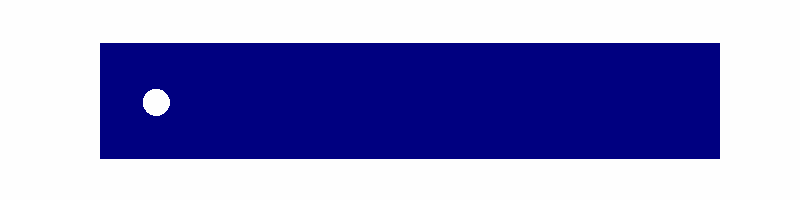

In [ ]:
from nstokes import visualize
visualize(u[0])

In [ ]:
from dlroms import*
mu, u = CPU.tensor(data['mu']), CPU.tensor(data['u'])

ndata, ntimes, nh = u.shape
p = mu.shape[-1]
print("Trajectories:\t%d." % ndata)
print("Timesteps:\t%d." % ntimes)
print("FOM dimension:\t%d." % nh)
print("Parameters:\t%d." % p)


mut = CPU.zeros(ndata, ntimes, p+1)
times = CPU.tensor(np.linspace(0, 3.5, ntimes))
for i in range(ndata):
    mut[i,:,:2] = mu[i]
    mut[i,:, 2] = times

Trajectories:	41.
Timesteps:	141.
FOM dimension:	6477.
Parameters:	2.


In [ ]:
u = u.reshape(-1, nh)
mut = mut.reshape(-1, p+1)

In [ ]:
from nstokes import Vm
l2 = L2(Vm)

ntrain = (ndata//2)*ntimes

def error(utrue, upred):
    return (l2(utrue-upred).reshape(-1, ntimes).sum(axis = -1)/l2(utrue).reshape(-1, ntimes).sum(axis = -1)).mean()

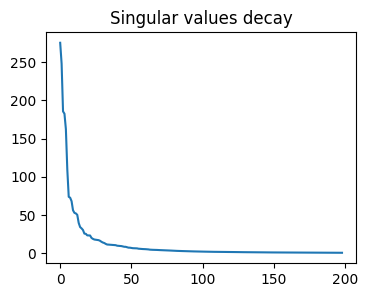

In [ ]:
# Preliminary check to justify the use of autoencoder.
from scipy.linalg import svd
import matplotlib.pyplot as plt

_, s, _ = svd(u[:ntrain].T.cpu().numpy(), full_matrices = True)
plt.figure(figsize = (4, 3))
plt.plot(s[1:200])
plt.title("Singular values decay")
plt.show()



**Need for Autoencoders**

The Navier-Stokes Equation is a non-linear Partial Differential Equation, so there is a need for using non-linear reduction techniques. If we had used POD-Galerkin, the singular-values decay would have required us to use 100 bases in the reduced model. However, a theorem by Professor Manzoni, Zunino, and Rares assures us that with an autoencoder, a latent dimension of 7 is sufficient.

Moreover, with POD-Galerkin, we would have had to use a time-stepping method in the latent space, which for non-linear problems is not trivial. With the autoencoder technique, we can instead treat time as a parameter and query our neural network at each time step independently from the others.

One drawback is that we cannot enforce the continuity of the solution in time, and we may have unphysical results if our neural network is not well-trained.

#### Theorem 3 (Franco, M., Zunino 2023)

Assume the parameter space is compact and the parameter-to-solution map is Lipschitz continuous. Additionally, assume that $\Psi$ and $\Psi'$ are s-times differentiable, $s \geq 2$, and have bounded derivatives. Then for any $\epsilon > 0$ there exists a DL-ROM such that

- $\Psi$ has $ C m^{1+n/(s-1)} \varepsilon^{-n/(s-1)} \log(m/\varepsilon) $ active weights and \( C \log(m/\varepsilon) \) layers,
- $\varphi$ has $ C \varepsilon^{-p} \log(1/\varepsilon) $ active weights and $ C \log(1/\varepsilon) $ layers,

and $ \mathcal{E}_A < 2\varepsilon $ where $ m := \min\{m \mid d_m(S) < \varepsilon\} $


Sinc ehere we have 2 parameters and time is treated as an additional parameter, we choose 2*(2+1)+1 = 7 latent dimension.


In the training it is important to use the $L^2$ error instead of the classical MSE since we are not dealing with a regular mesh, in some part of the domain points are denser nd in other coarser, thus the classical MSE is not a suitabe measure of the error in this case. Obviously, the use of the $L^2$ norm makes training more expensive, since during error calculation it is required to perform numerical integration.The network with 50 epochs is undertrained. It would benefit of more epochs, however I have been having problem with GPUs on Colab and so due to time constraints I had to use CPU.

In [ ]:
u.shape,mut.shape


(torch.Size([5781, 6477]), torch.Size([5781, 3]))

In [ ]:
latent = 7
encoder = Dense(nh, 30) + Dense(30, latent)
decoder = Dense(latent, 30) + Dense(30, 60) + Dense(60, nh, activation = None)
autoencoder = DFNN(encoder + decoder)
autoencoder.He()
autoencoder.train(u, u, ntrain = ntrain, epochs = 50, loss = mse(l2), error = error)
autoencoder.freeze()








**Fourier Modes Embedding**

Fourier modes are used to capture periodic components in the data. By representing functions as a sum of sine and cosine terms, Fourier modes provide an efficient way to encode oscillatory patterns, which are common in solutions of PDEs like the Navier-Stokes equations. The Fourier transformation is applied to the input parameters, enhancing the neural network's ability to learn complex mappings.

In [ ]:
from utils import Fourier
from dlroms import*

nu = encoder(u)
nu_mean, nu_std = nu[:ntrain].mean(axis = 0), nu[:ntrain].var(axis = 0).sqrt()
nu = (nu - nu_mean)/nu_std

fmodes = 10
phi = DFNN(Fourier(fmodes) + Dense(p+1+2*fmodes, 500) + Dense(500, latent, activation = None))

phi.He()
phi.train(mut, nu, ntrain = ntrain, epochs = 1000, loss = mse(euclidean))

phi.freeze()

		Train		Test
Epoch 2000:	7.20e-03	3.48e-02.

>> ETA: 0.52s.

Training complete. Elapsed time: 17 minutes 29.25 seconds.


In [ ]:
num2p(error(u[ntrain:], autoencoder(u[ntrain:])))

'3.88%'